<a href="https://colab.research.google.com/github/valerian-drmt/Finance/blob/main/Projects/LSTM_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import vectorbt as vbt
import time
import yfinance as yf
import torch
import torch.nn as nn

| Interval       | Max Lookback Period (approx)  |
|----------------|-------------------------------|
| `'1m'`         | 7 days                        |
| `'2m'`         | 60 days                       |
| `'5m'`         | 60 days                       |
| `'15m'`        | 60 days                       |
| `'30m'`        | 60 days                       |
| `'60m'` / `'1h'` | 730 days (~2 years)        |
| `'1d'`         | ~20+ years                    |
| `'1wk'`        | ~20+ years                    |
| `'1mo'`        | ~20+ years                    |

In [3]:
#data_request = vbt.BinanceData.download("BTCUSDT", start="2025-04-14", end="2025-04-17", interval="1m")
data_request = vbt.YFData.download("BTC-USD", start="2025-04-14", end="2025-04-17", interval="1m")
data = data_request.get()
print(data.head())
print(data["Volume"].iloc[-1])
time.sleep(3)

data_request = data_request.update()
data = data_request.get()
print(data["Volume"].iloc[-1])


                                   Open          High           Low  \
Datetime                                                              
2025-04-14 00:00:00+00:00  83714.000000  83714.000000  83714.000000   
2025-04-14 00:01:00+00:00  83706.945312  83706.945312  83706.945312   
2025-04-14 00:02:00+00:00  83741.062500  83741.062500  83741.062500   
2025-04-14 00:03:00+00:00  83729.085938  83729.085938  83729.085938   
2025-04-14 00:04:00+00:00  83800.125000  83800.125000  83800.125000   

                                  Close     Volume  Dividends  Stock Splits  
Datetime                                                                     
2025-04-14 00:00:00+00:00  83714.000000          0        0.0           0.0  
2025-04-14 00:01:00+00:00  83706.945312          0        0.0           0.0  
2025-04-14 00:02:00+00:00  83741.062500   38641664        0.0           0.0  
2025-04-14 00:03:00+00:00  83729.085938   94318592        0.0           0.0  
2025-04-14 00:04:00+00:00  83800.1

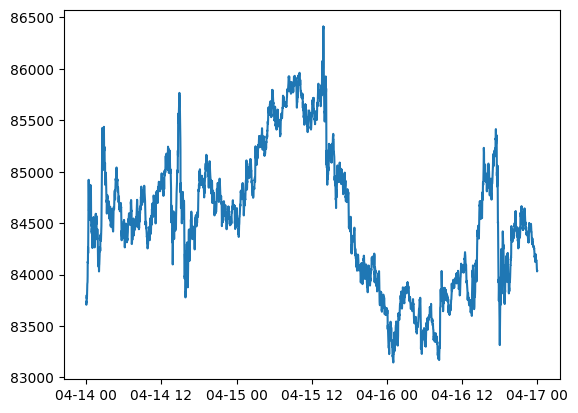

In [7]:
data.vbt.ohlcv.plot(plot_type="candlestick",show_volume=True)
plt.plot(data.index,data["Close"])

input = pd.DataFrame(index = data.index, data = {"Close":data["Close"]})
input = (input-input.min())/(input.max()-input.min())

In [15]:
def split_data(input, lookback, size_test_prct):
    data_raw = np.array(input) # convert to numpy array
    data = []
    lookback+=1 # +1 for output variable

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)

    test_set_size = int(np.round(size_test_prct*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    print(x_train.shape)
    print(y_train.shape)
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    print(x_test.shape)
    print(y_test.shape)

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)

    return [x_train, y_train, x_test, y_test]

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [31]:
lookback = 20 # choose sequence length
size_test_prct = 0.3
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [32]:
x_train, y_train, x_test, y_test = split_data(input, lookback, size_test_prct)

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

#MSE
hist_mse = np.zeros(num_epochs)
MSE = torch.nn.MSELoss(reduction='mean')

#RMSE = squared de MSE
hist_rmse = np.zeros(num_epochs)

#MAE
hist_mae = np.zeros(num_epochs)
MAE = torch.nn.L1Loss(reduction='mean')

#R2
hist_r2 = np.zeros(num_epochs)

#MAPE
hist_mape = np.zeros(num_epochs)

lstm = []

(2873, 20, 1)
(2873, 1)
(1231, 20, 1)
(1231, 1)


In [33]:
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train)

    mse_value = MSE(y_train_pred, y_train)
    rmse_value = np.sqrt(mse_value.item())
    mae_value = MAE(y_train_pred, y_train)

    print(f"Epoch {t+1} / MSE: {mse_value.item():.5f} / RMSE: {rmse_value:.5f} / MAE: {mae_value.item():.5f}")

    hist_mse[t] = mse_value.item()
    hist_rmse[t] = rmse_value.item()
    hist_mae[t] = mae_value.item()

    optimiser.zero_grad()
    mse_value.backward()
    optimiser.step()

training_time = time.time()-start_time

print("Training time: {}".format(training_time))

Epoch 1 / MSE: 0.40127 / RMSE: 0.63346 / MAE: 0.60465
Epoch 2 / MSE: 0.20253 / RMSE: 0.45003 / MAE: 0.41219
Epoch 3 / MSE: 0.04335 / RMSE: 0.20821 / MAE: 0.16894
Epoch 4 / MSE: 0.21504 / RMSE: 0.46372 / MAE: 0.43804
Epoch 5 / MSE: 0.06284 / RMSE: 0.25068 / MAE: 0.21033
Epoch 6 / MSE: 0.02905 / RMSE: 0.17043 / MAE: 0.13408
Epoch 7 / MSE: 0.04373 / RMSE: 0.20913 / MAE: 0.16876
Epoch 8 / MSE: 0.05890 / RMSE: 0.24269 / MAE: 0.20193
Epoch 9 / MSE: 0.06618 / RMSE: 0.25725 / MAE: 0.21586
Epoch 10 / MSE: 0.06641 / RMSE: 0.25771 / MAE: 0.21625
Epoch 11 / MSE: 0.06183 / RMSE: 0.24866 / MAE: 0.20750
Epoch 12 / MSE: 0.05456 / RMSE: 0.23358 / MAE: 0.19289
Epoch 13 / MSE: 0.04645 / RMSE: 0.21553 / MAE: 0.17468
Epoch 14 / MSE: 0.03908 / RMSE: 0.19767 / MAE: 0.15666
Epoch 15 / MSE: 0.03366 / RMSE: 0.18347 / MAE: 0.14391
Epoch 16 / MSE: 0.03096 / RMSE: 0.17595 / MAE: 0.13826
Epoch 17 / MSE: 0.03104 / RMSE: 0.17619 / MAE: 0.13998
Epoch 18 / MSE: 0.03323 / RMSE: 0.18228 / MAE: 0.14721
Epoch 19 / MSE: 0.0

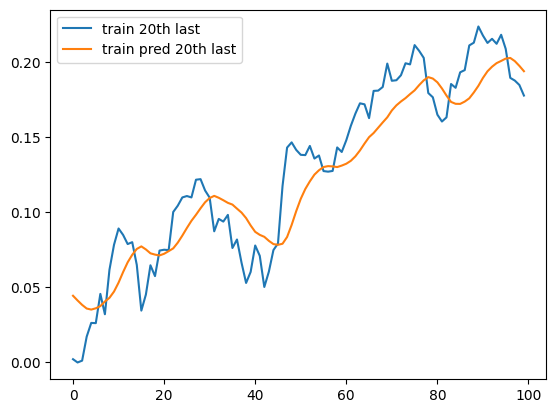

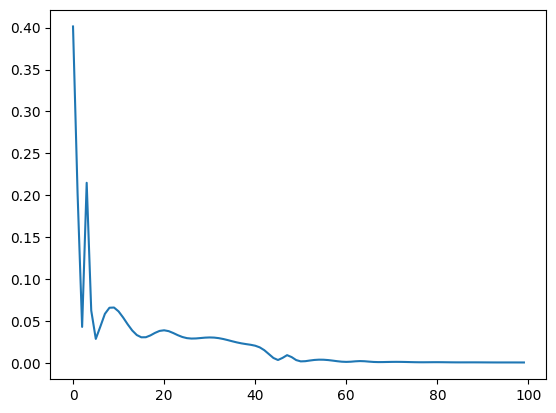

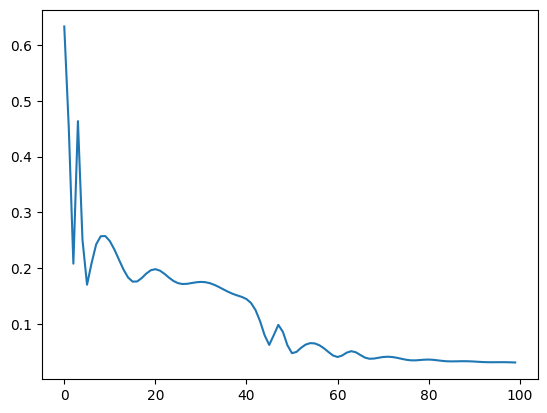

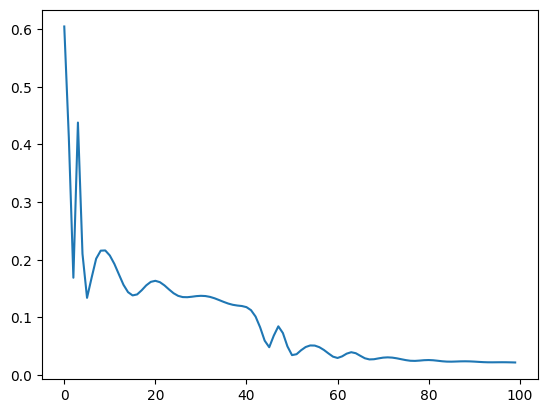

In [34]:
y_train = y_train.detach().cpu().numpy()
y_train_pred = y_train_pred.detach().cpu().numpy()
plt.plot(y_train[-lookback*5:], label=f"train {lookback}th last")
plt.plot(y_train_pred[-lookback*5:], label=f"train pred {lookback}th last")
plt.legend()
plt.show()

plt.plot(hist_mse)
plt.show()
plt.plot(hist_rmse)
plt.show()
plt.plot(hist_mae)
plt.show()